In [1]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
times = pd.read_csv('data/routeCNtimes.csv')

def mae_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

def try_thetas(thetas, y_vals, xlims, loss_fn=mae_loss, figsize=(10, 7), cols=3):
    if not isinstance(y_vals, np.ndarray):
        y_vals = np.array(y_vals)
    rows = int(np.ceil(len(thetas) / cols))
    plt.figure(figsize=figsize)
    for i, theta in enumerate(thetas):
        ax = plt.subplot(rows, cols, i + 1)
        sns.rugplot(y_vals, height=0.1, ax=ax)
        plt.axvline(theta, linestyle='--',
                    label=rf'$ \theta = {theta} $')
        plt.title(f'Loss = {loss_fn(theta, y_vals):.2f}')
        plt.xlim(*xlims)
        plt.yticks([])
        plt.legend()
    plt.tight_layout()

# Loss Functions

We would like to model how late a bus is with a constant, called $\theta$, and we would like to use the collected data on bus times to figure out a good value for $\theta$.
Generally, a *loss function* measures what we lose by summarizing our data by a model of some kind.
Here, we are looking at models that consist only of a constant. 

A loss function is a mathematical function that takes in a $\theta$ value and a data value,
which we write as $y$. It outputs a single number, the *loss*, that measures how well $\theta$ fits our data value. We represent the loss function as, ${\cal l}(\theta, y)$.

By convention, the loss function outputs lower values for preferable values of $\theta$ and larger values for a worse $\theta$. To fit a model to our data, we select the particular $\theta$ that produces a lower average loss than all other choices; in other words we find the $\theta$ that *minimizes the average loss* for our data, $y_1, \ldots, y_n$. We write the average loss as $L(\theta, y_1, y_2, \ldots, y_n)$, where

$$
\begin{aligned}
L(\theta, y_1, y_2, \ldots, y_n)
&= \text{average}\left\{ {\cal l}(\theta, y_1), {\cal l}(\theta, y_2), \ldots, {\cal l}(\theta, y_n) \right\} \\
&= \frac{1}{n} \sum_{i = 1}^{n} {\cal l}(\theta, y_i)\\
\end{aligned}
$$

As a shorthand, we often define the vector $ \textbf{y} = [ y_1, y_2, \ldots, y_n ] $, and then, we can write the average loss as:

$$
L(\theta, \textbf{y})
= \frac{1}{n} \sum_{i = 1}^{n}l(\theta, {y_i})\\
$$

We consider two loss functions, absolute error and square error.

## Mean Absolute Error

We start with the *absolute error* loss function. Here's the idea behind absolute loss: 

1. For some value of $\theta$ and data value $y$, 
1. Find the error: $y - \theta$ and
1. Take the absolute value of the error: $|y - \theta|$. 

Taking the absolute value of the error is a simple way to convert negative errors into positive ones. We want to do this because, say, if our point, $y=4$, is equally far away from $\theta = 2$ and $\theta = 6$, the errors are equally "bad".

We want to use all of our data to find the best $\theta$ so we compute what is called mean absolute error, or MAE for short.  The MAE is the average of each of the individual absolute errors:

$$
L(\theta, {\bf y})
= \frac{1}{n} \sum_{i = 1}^{n} |y_i - \theta|\\
$$

Notice that the name MAE, tells you how to compute it--take the mean of the absolute errors. We use the notation $\hat{\theta}$ to denote the minimizing value of $L(\theta, {\bf y})$.

We can write a simple Python function to compute this loss:

In [3]:
def mae_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

Let's see how this loss function behaves when we have just five points $[ -1, 0, 2, 5, 10]$. We can try different values of $\theta$ and see what the loss function outputs for each value.

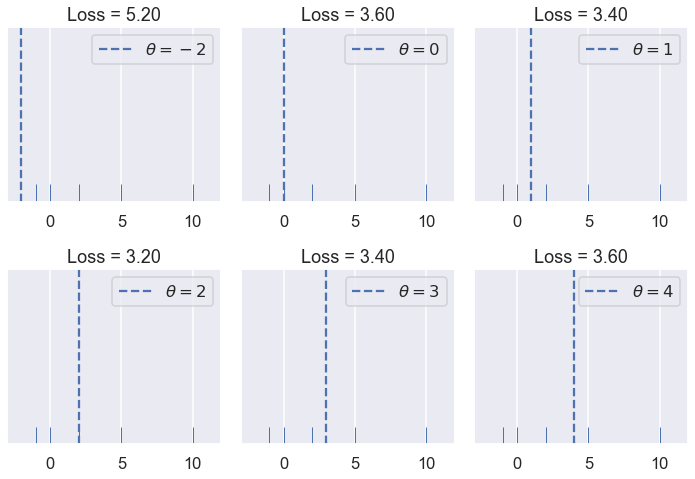

In [4]:
try_thetas(thetas=[-2, 0, 1, 2, 3, 4],
           y_vals=[-1, 0, 2, 5, 10],
           xlims=(-3, 12))

Of the values of $\theta$ that we tried, we found that $ \theta = 2 $ has the lowest mean absolute error. It is no accident that this value corresponds to the median of the data values. Let's now see what the loss function outputs on the original dataset of bus times. Let's try the median, mean, and mode of the data as values for $\theta$.

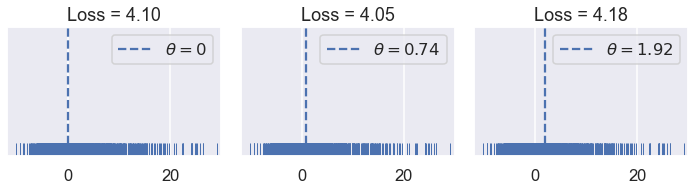

In [5]:
try_thetas(thetas=[0, 0.74, 1.92],
           y_vals=times['minutes_late'],
           xlims=(-12, 30), figsize=(10, 3))

It looks like the median is again the best choice for $\theta$, at least compared to the mode and mean.  In fact, it can be proved that for absolute loss, the minimizing $\hat{\theta}$ is the median of $\{ y_1, y_2, \ldots, y_n \}$.

So far, we have found the best value of $ \theta $ by simply trying out a bunch of values and then picking the one with the smallest loss. To get a better sense of the MAE as a function of $\theta$, we can try many more values of $\theta$ to see a complete curve that shows how $L(\theta, {\bf{y}})$ changes as $\theta$ changes.
We draw the curve for the example from above with the five data values, $[ -1, 0, 2, 5, 10]$.

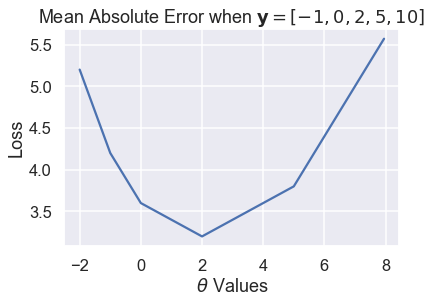

In [6]:
thetas = np.arange(-2, 8, 0.05)
y_vals=np.array([-1, 0, 2, 5, 10])
losses = [mae_loss(theta, y_vals) for theta in thetas]

plt.plot(thetas, losses)
plt.title(r'Mean Absolute Error when $\bf{y}$$ = [-1, 0, 2, 5, 10] $')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss');

The plot above shows that in fact, $ \theta = 2$ is the best choice for the small dataset of five values.  Notice the shape of curve. It is piecewise linear, where the line segments connect at the location of the data values (-1, 0, 2, and 5). This is a property of the absolute value function.
With a lot of data, the flat pieces are less obvious. For example, the MAE curve for our data appears below.  

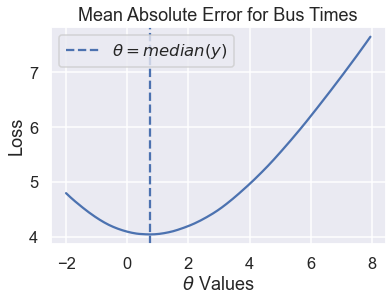

In [14]:
thetas = np.arange(-2, 8, 0.05)
y_vals=times['minutes_late']
losses = [mae_loss(theta, y_vals) for theta in thetas]

plt.plot(thetas, losses)
plt.axvline(np.median(y_vals), linestyle='--',
                    label=rf'$\theta = median(y)$')
plt.title(r'Mean Absolute Error for Bus Times')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

For now, we can use this plot to confirm that the median of the data is the minimizing value, in other words $\hat \theta = 0.74$. Next we consider a loss function based on squaring the errors.  

## Mean Squared Error

We have used a constant model for our data and found that with mean absolute error, the minimizer is the median. Now, we will keep our model the same but switch to a different loss function: squared error. Instead of taking the absolute difference between our data value $y$ and the constant $\theta$, we square the error:

1. For some value of $\theta$ and data value $y$, 
1. Find the error: $y - \theta$ and
1. Take the squared value of the error: $(y - \theta)^2$. 

As before, we want to use all of our data to find the best $\theta$ so we compute the mean squared error, or MSE for short:

$$
L(\theta, {\bf y}) = L(\theta, y_1, y_2, \ldots, y_n)
= \frac{1}{n} \sum_{i = 1}^{n} (y_i - \theta)^2
$$

We can write a simple Python function to compute the MSE:

In [8]:
def mse_loss(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

Let's again try the mean, median, and mode as potential minimizers of the MSE.

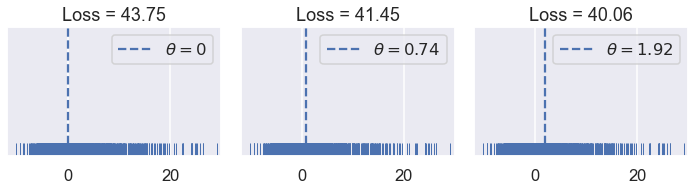

In [9]:
try_thetas(thetas=[0, 0.74, 1.92],
           y_vals=times['minutes_late'],
           xlims=(-12, 30), loss_fn=mse_loss, figsize=(10, 3))

Now, when we fit the constant model using MSE loss, we find that $\text{mean}(\textbf{y})$ has a smaller loss than the mode and the median. A plot of MSE as a function of $\theta$ (and based on our data) appears below, where we can see the minimizing value is close to 2.

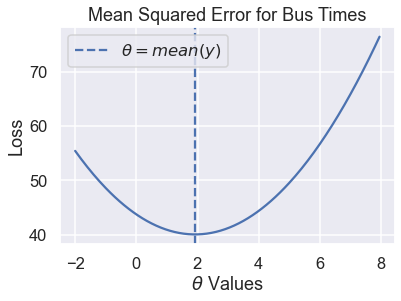

In [16]:
thetas = np.arange(-2, 8, 0.05)
y_vals=times['minutes_late']
losses = [mse_loss(theta, y_vals) for theta in thetas]

plt.plot(thetas, losses)
plt.axvline(np.mean(y_vals), linestyle='--',
                    label=rf'$\theta = mean(y)$')
plt.title(r'Mean Squared Error for Bus Times')
plt.xlabel(r'$ \theta $ Values')
plt.ylabel('Loss')
plt.legend();

One feature of this curve that is quite noticable is how rapidly large the MSE grows compared to  the MAE. This growth has to do with the nature of squaring errors; it places a much higher loss on data values further away. If $\theta = 10$ and $y = 110$, the squared loss is $(10 - 110)^2 = 10000$ whereas the absolute loss is $|10 - 110| = 100$. For this reason, MSE is more sensitive to outliers than MAE.

Fitting the constant model using MSE loss, we have observed that $ \hat{\theta} = \text{mean} (\textbf{y})$.  Again, this no mere coincidence; the average of the data *always* produces the $ \theta $ that minimizes the MSE. We can show this with calculus. We take the derivative of our average loss function. 

$$
\begin{aligned}
L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - \theta)^2\\
\frac{\partial}{\partial \theta} L(\theta, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n} -2(y_i - \theta) \\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - \theta) \\
\end{aligned}
$$

Then, we set the derivative to 0 and solve for $\hat \theta$: 

$$
\begin{aligned}
0
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - {\hat \theta}) \\
{\hat \theta}
&= \frac{1}{n} \sum_{i = 1}^{n} y_i \\
\end{aligned}
$$

Lo and behold, we see that there is a single value of $\theta$ that gives the smallest possible MSE no matter what the dataset is. For the mean squared error, we have shown that ${\hat \theta}= {\bar y}$. (A second derivative confirms that $\bar{y}$ is a minimizer). 

There are many possible loss functions to use when fitting models to data. The squared loss is the most common, but absolute loss is also popular. The choice of the loss function, even in the simple case of modelling a constant can yield different estimates and choosing the loss function is a crucual step.